# Assignment 1 - Inverse Problems 2023 - Emilie Jessen

In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import linalg
from matplotlib.patches import Rectangle

In [2]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

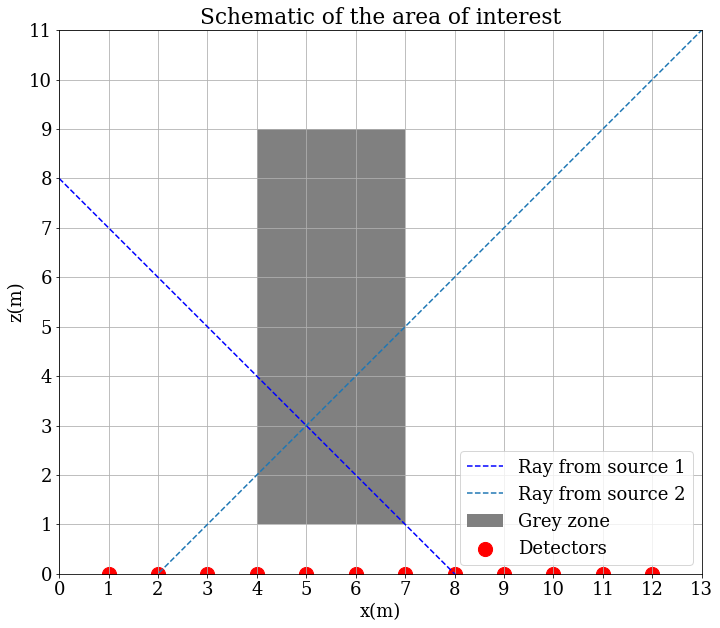

In [29]:
# Schematic of the area of interest
area = np.ones((11, 13)) * 5

x = np.linspace(0, 13, 100)

fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(area, cmap='Greys', interpolation='nearest')
ax.add_patch(Rectangle((4, 1), 3, 8, facecolor = 'grey', fill=True, label='Grey zone'))
ax.scatter(np.arange(1, 13), np.zeros(12), color='red', s=200, label='Detectors')
ax.plot(x, -x+8, color='b', linestyle='--', label='Ray from source 1')
ax.plot(x, x-2, linestyle='--',label='Ray from source 2')
ax.grid()
ax.set(xlabel='x(m)',
       xticks=np.arange(0, 14, 1),
       ylabel='z(m)',
       yticks=np.arange(0, 12, 1), 
       xlim=(0,13),
       ylim=(0,11),
       title='Schematic of the area of interest')
ax.legend();

## The direct problem 

1. Calculation of arrival-time anomalies. See code below. 

In [76]:
# Setting up parameters
v0 = 5.0
v_box = 5.2
const = (1/v0 - 1/v_box) * np.sqrt(2)

def time_anomalies(matrix):
    """Function to calculate the time anomalies for the 12 detectors from the two sources.
    The function takes a matrix as input, which is the area of interest discretized into 1m x 1m squares 
    and has the value 1 in the grey zone and 0 elsewhere.
    For each ray the function sums the value of squares, that the ray passes through.
    The sum is then multiplied by the constant, which is the difference in the inverse velocities
    and the square root of 2. The result is the time anomaly for each ray.
    The order of the t-array is: detector 1 to 12 for source 1, then detector 1 to 12 for source 2."""

    # Summing up the distances for the rays inside the grey zone to each of the detectors
    sums_s1 = np.zeros(12)    # Source 1
    sums_s2 = np.zeros(12)    # Source 2

    for i in range(11):
        sums_s1[i] = np.sum(np.diag(np.fliplr(matrix), k=i+1))  # Source 1
        sums_s2[i] = np.sum(np.diag(matrix, k=i+1))             # Source 2

    sums_s1 = sums_s1[::-1]

    # Concatenating the distances for the rays of the two sources in one array:
    distances = np.concatenate((sums_s1, sums_s2))

    t = const * distances

    return t


# Creating the area matrix and the location of the grey zone
# Discretising the box into 1m x 1m squares
area_matrix = np.zeros((11, 13))
area_matrix[1:9, 4:7] = 1

# Calculating the time anomalies: 
t_pure = time_anomalies(area_matrix)

print('The time anomalies for the 12 detectors from source 1 are:\n', np.round(t_pure[:12],3))

print('\nThe time anomalies for the 12 detectors from source 2 are:\n', np.round(t_pure[12:],3))

The time anomalies for the 12 detectors from source 1 are:
 [0.    0.    0.    0.    0.    0.011 0.022 0.033 0.033 0.033 0.033 0.033]

The time anomalies for the 12 detectors from source 2 are:
 [0.033 0.033 0.033 0.022 0.011 0.    0.    0.    0.    0.    0.    0.   ]


2. Equation 1 is discretized in the following way: 

$$t_{\gamma} = \sqrt{2}(\frac{1}{v_0} - \frac{1}{v_G}) \sum_j G_{\gamma, j} \cdot m_j $$

where 
- $t_{\gamma}$: the arrival time anomaly for a wave propagating along a ray $\gamma$
- $v_0$: the wave propagation velocity outside the grey zone. 
- $v_G$: the wave propagation velocity inside the grey zone. 
- $G_{\gamma}$: matrix describing the path of the rays. This matrix is constructed by creating a 13x11 matrix for each of the rays, where the value 1 is assigned to all the squares where the ray passes through and 0 to the others. The matrices for each of the rays are then flattened and stacked vertically to create the final matrix G. In this way, each row in G will describe one ray $\gamma$ path through the area. The factor of $\sqrt{2}$ is to get the correct distance.
- $m$: the vector containing the information on the location of the grey zone. The vector is obtained by flattening the 13x11 area matrix, which has the value 1 assigned to the squares included in the grey zone and the value 0 to the squares not included in the grey zone. 

## The inverse problem

3. Formulate the discrete inverse problem 

This is done by creating the vector m and the matrix G in the code below by the method described above.

In [5]:
# The forward relation d = Gm. Creating m, which contains the information of the box:
m = area_matrix.flatten()

# Creating the G matrix:
G = np.zeros((24, 143))

# G contains the information of the rays from source 1 and 2:
for i in range(12):
    G[i, :] = np.fliplr(np.eye(11, 13, k=12-i)).flatten()  # Source 1
    G[i+12, :] = np.eye(11, 13, k=i+1).flatten()           # Source 2

Ray 1-12 is from source 1, and ray 13-24 is from source 2


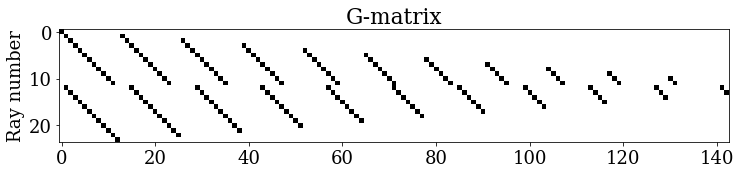

In [6]:
# Plotting matrix G:
fig, ax = plt.subplots(figsize=(12, 10))

ax.imshow(G, cmap='Greys', interpolation='nearest')
ax.set(ylabel='Ray number',
       title='G-matrix');

print('Ray 1-12 is from source 1, and ray 13-24 is from source 2')

4. The problem can be described as a matrix equation, whereby it is shown that the problem is linear. 

5. The solution to the problem is not unique, as there are 143 model parameters and 24 data points. The system is under-determined. 

In [17]:
def get_data(t_pure):
    """Function to simulate the observed data vector t_obs by adding noise to the pure data vector t_pure.
    The noise is drawn from a normal distribution with mean 0 and standard deviation 1.
    The noise distribution is scaled to satisfy eq.3 in the report."""

    # The norm of the calculated time anomalies:
    norm_t_pure = np.linalg.norm(t_pure)

    # The noise norm defined in eq.3:
    noise_norm = 1 / 18 * norm_t_pure

    # The noise distribution - drawing 24 random numbers from a normal distribution:
    n_distribution = np.random.normal(0, 1, len(t_pure))

    # The noise distribution is scaled to the noise norm:
    # Divided by its own norm to normalize it, then multiplied by the noise norm to satisfy eq.3
    n_distribution *= noise_norm / np.linalg.norm(n_distribution) 

    # Creating the "observed" time anomalies:
    t_obs = t_pure + n_distribution

    return t_obs, noise_norm

In [18]:
def Tikhonov(epsilon, G, t_obs): 
    """Function to estimate the model m_tilde, i.e. the position of the grey using Tikhonov regularization.
    For each epsilon the function calulates m_tilde using the normal eqs.
    For each epsilon the function also calculates the error norm |t_obs - Gm|^2."""

    # Save model parameters i.e. the estimate of the position of the box:
    # Save the error norm |t_obs - Gm|^2
    model = []
    error_norm = []

    # Loop through the different epsilon values:
    for i in epsilon:
        m_tilde = np.linalg.inv(G.T @ G + i**2 * np.eye(143)) @ G.T @ t_obs     # Normal egs. 
        model.append(m_tilde)
        error_norm.append(np.linalg.norm(t_obs - G @ m_tilde)**2)

    return model, error_norm

In [19]:
# Compute the "observed" time anomalies and the noise norm, i.e. uncertainties:
t_obs, noise_norm = get_data(t_pure)

# The criterion for choosing regularization parameter epsilon: N * sigma^2
criterium = len(t_obs) * noise_norm**2

# Different values of epsilon to try in Tikhonov regularization:
epsilon = np.linspace(0.1, 5, 100)

# Compute the model for each epsilon and the error norm:
model, error_norm = Tikhonov(epsilon, G, t_obs)

In [20]:
def optimum(epsilon, error_norm, criterium, model):
    """Function to find the best epsilon value that satisfies the criterion.
    The function returns the index and value of the epsilon that is closest to satisfy the criterion 
     and the corresponding model parameters. """

    # Finding the index of the epsilon that is closest to satisfy the criterium:
    eps_best_idx = np.argmin(abs(error_norm - criterium))

    # Getting the best epsilon and corresponding model parameters:
    epsilon_best = epsilon[eps_best_idx]
    m_best = model[eps_best_idx]

    return eps_best_idx, epsilon_best, m_best

# Finding the index of the epsilon that is closest to satisfy the criterium:
eps_best_idx, epsilon_best, m_best = optimum(epsilon, error_norm, criterium, model)

In [68]:
def plot_results(area, m_best, epsilon, error_norm, criterium, eps_best_idx, epsilon_best):
    """Function to plot the results of the Tikhonov regularization."""

    fig, axs = plt.subplots(ncols=3, figsize=(21, 7), gridspec_kw={'width_ratios': [1.15, 1.25, 1.15]})

    axs[0].imshow(area, cmap='Greys', interpolation='nearest')
    axs[0].set(xlabel='x(m)',
           xticks=np.arange(0, 14, 1),
           ylabel='z(m)',
           yticks=np.arange(0, 12, 1), 
           xlim=(0,13),
           ylim=(0,11),
           title='True model')
    
    plot_ax1 = axs[1].imshow(m_best.reshape(11, 13), cmap='Greys', interpolation='nearest')
    axs[1].set(xlabel='x(m)', 
              xticks=np.arange(0, 14, 1),
              ylabel='z(m)', 
              yticks=np.arange(0, 12, 1), 
              xlim=(0,13),
              ylim=(0,11),
              title='Estimated model');
    
    plt.colorbar(plot_ax1,ax=axs[1], fraction=0.04, pad=0.04)

    axs[2].plot(epsilon, error_norm, color='darkblue', label='Error norm')
    axs[2].hlines(criterium, epsilon[0], epsilon[-1], color='red', linestyle='--', label=r'$|t_{obs} - Gm|^2 \approx N \sigma^2$')
    axs[2].scatter(epsilon_best, error_norm[eps_best_idx], marker='o', color='red', s=200, label=r'$\epsilon_{best}$= %.2f' % epsilon_best)
    axs[2].yaxis.tick_right()
    axs[2].set(xlabel='$\epsilon$',
           ylabel='$|t_{obs} - Gm|^2$',
           title='Error norm as a function of $\epsilon$')

    axs[2].legend()
    fig.tight_layout();

6. A solution to the discrete inverse problem has been computed and is shown below. 
Tikhonov regularization can be used on mixed-determined systems, i.e. systems, which are both over- and under-determined or it can be used on under-determined problems, as in this case. 
Tikhonov regularization is based on the minimization of (for appropriate $\epsilon$ > 0): 

$$|| \mathbf{Gm} - \mathbf{d_{obs}}||^2 - \epsilon^2||\mathbf{m}||^2 $$

This can be done by solving the normal equations for different values of $\epsilon$:

$$ \mathbf{\tilde{m}} = (\mathbf{G}^T\mathbf{G} + \epsilon^2\mathbf{I})^{-1} \mathbf{G}^T \mathbf{d_{obs}} $$

The optimal $\epsilon$-value is the one satisfying: 
$$ ||\mathbf{G\tilde{m}}-\mathbf{d_{obs}}|| \approx N\sigma^2 $$

where N is the number of data point (24) and $\sigma$ is the norm of the noise distribution described in eq. 3 in the report.

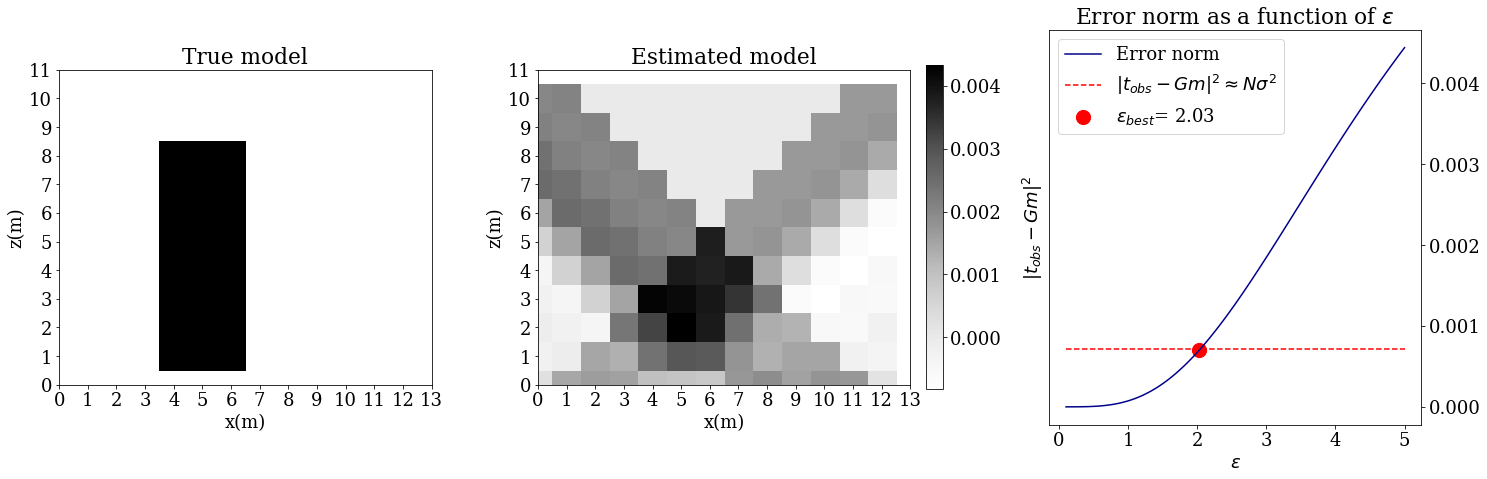

In [69]:
# Plotting the result of the Tikhonov regularization for the optimal epsilon:
plot_results(area_matrix, m_best, epsilon, error_norm, criterium, eps_best_idx, epsilon_best)

7. Comments of the estimated model for delta functions as the true model: In the code below, the inverse operator is used on a delta function with zero everywhere except in a single 1 x 1m square. 
In the first case, two rays passes through the square and the estimated model is doing a fine job of locating the square. The estimated model is assigning a higher wave propagation velocity along the path of the two rays (dark grey squares along diagonals), as we also saw for the full problem. In the surrounding area the wave propagation velocity is differing a little which is due to noise.  
In the second case, only one ray passes through the square in the true model, and the estimated model therefore assigns the same wave propagation velocity to all the squares along the path of the ray and is unable to locate a single position for the square in the true model. 

8. Comments on the estimated model on the full problem: The estimated model is able to figure out, that a zone (the black squares in the estimated model) with a higher wave propagation velocity than the surrounding area exist. The estimated model locates that part of the zone with most rays passing through in the true model with the highest accuracy. The estimated model also assigns a higher wave propagation velocity than the surroundings to the squares (the grey diagonals in the estimated model), where the rays in the true model are travelling the longest distance in the grey zone. The estimated model is not able to capture the hard boundary of the grey zone in the true model. The true model has an absence of noise, which is visible in the estimated model, as the surrounding area has varying wave propagation velocities. 


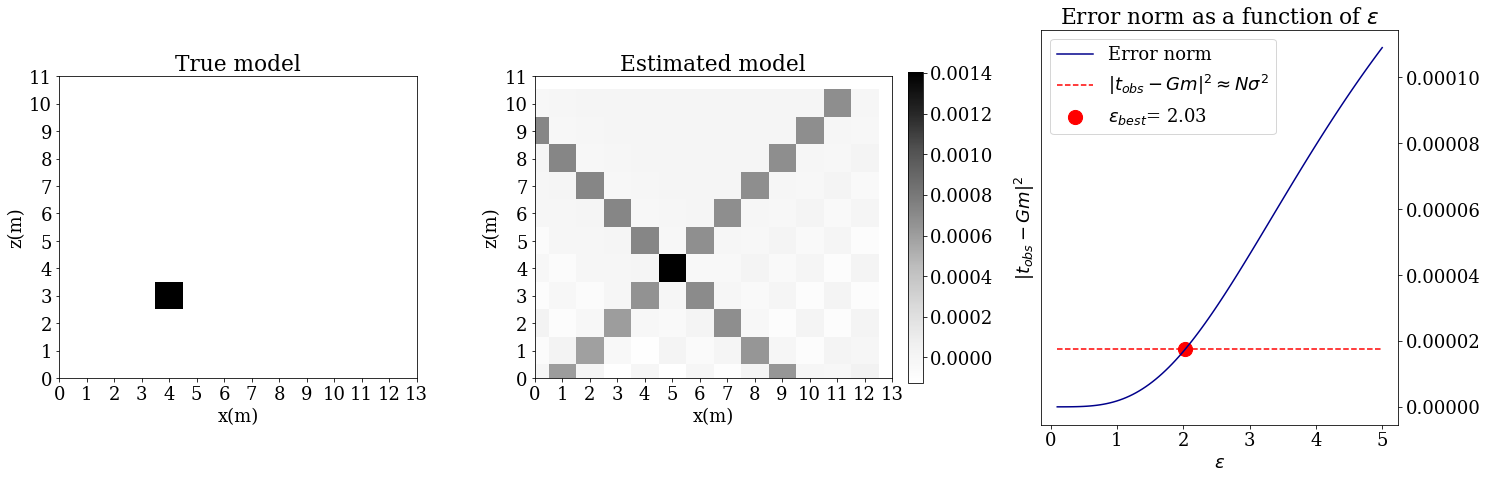

In [72]:
# Counstructing the true model as a delta function: 
m_single_sq = np.zeros(shape=(13,11))
m_single_sq[3,4] = 1

# Getting the time anomalies for the true model:
t_pure_sq = time_anomalies(m_single_sq)

# Compute the "observed" time anomalies and the noise norm, i.e. uncertainties:
t_obs_sq, noise_norm_sq = get_data(t_pure_sq)

# Finding solution with Tikhonov regularization:
model_sq, error_norm_sq = Tikhonov(epsilon, G, t_obs_sq)

# The criterion for choosing regularization parameter epsilon: N * sigma^2
criterium_sq = len(t_obs_sq) * noise_norm_sq**2

# Finding the best epsilon and corresponding model parameters:
eps_best_idx_sq, epsilon_best_sq, m_best_sq = optimum(epsilon, error_norm_sq, criterium_sq, model_sq)

# Plotting the results: 
plot_results(m_single_sq, m_best_sq, epsilon, error_norm_sq, criterium_sq, eps_best_idx_sq, epsilon_best_sq)

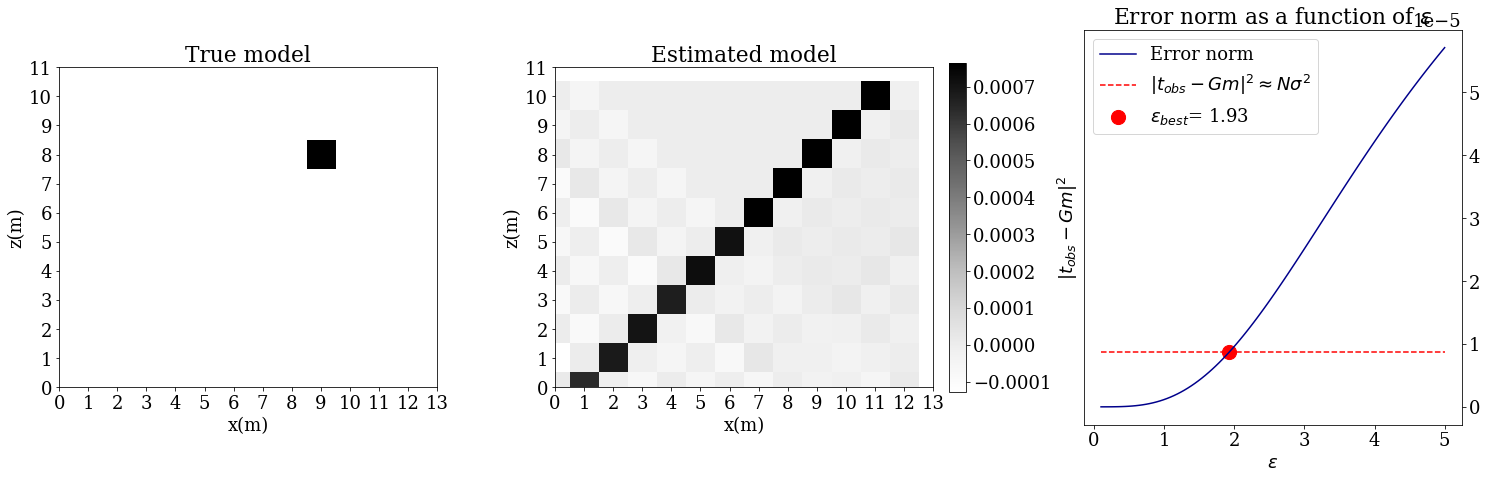

In [73]:
# Counstructing the true model as a delta function: 
m_single_sq = np.zeros(shape=(13,11))
m_single_sq[8,9] = 1

# Getting the time anomalies for the true model:
t_pure_sq = time_anomalies(m_single_sq)

# Compute the "observed" time anomalies and the noise norm, i.e. uncertainties:
t_obs_sq, noise_norm_sq = get_data(t_pure_sq)

# Finding solution with Tikhonov regularization:
model_sq, error_norm_sq = Tikhonov(epsilon, G, t_obs_sq)

# The criterion for choosing regularization parameter epsilon: N * sigma^2
criterium_sq = len(t_obs_sq) * noise_norm_sq**2

# Finding the best epsilon and corresponding model parameters:
eps_best_idx_sq, epsilon_best_sq, m_best_sq = optimum(epsilon, error_norm_sq, criterium_sq, model_sq)

# Plotting the results: 
plot_results(m_single_sq, m_best_sq, epsilon, error_norm_sq, criterium_sq, eps_best_idx_sq, epsilon_best_sq)